# Don't Eat The Onion

# Imports

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from tokenizers import ByteLevelBPETokenizer
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from wordcloud import WordCloud

# Import dataset

In [ ]:
data = pd.read_csv('/content/OnionOrNot.csv')
original_data = pd.read_csv('/content/OnionOrNot.csv')

In [ ]:
data.head()

,text,label
0,Entire Facebook Staff Laughs As Man Tightens P...,1
1,Muslim Woman Denied Soda Can for Fear She Coul...,0
2,Bold Move: Hulu Has Announced That They’re Gon...,1
3,Despondent Jeff Bezos Realizes He’ll Have To W...,1
4,"For men looking for great single women, online...",1


# Preprocessing

In [ ]:

nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    original_length = len(text.split())
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    stop_words_count = len(words) - len(filtered_words)

    return ' '.join(filtered_words), stop_words_count, original_length

data['processed_text'], data['stop_words_count'], data['original_length'] = zip(*data['text'].apply(preprocess_text))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data.head()

,text,label,processed_text,stop_words_count,original_length
0,Entire Facebook Staff Laughs As Man Tightens P...,1,entire facebook staff laugh man tightens priva...,1,9
1,Muslim Woman Denied Soda Can for Fear She Coul...,0,muslim woman denied soda fear could use weapon,6,14
2,Bold Move: Hulu Has Announced That They’re Gon...,1,bold move hulu announced theyre gonna go ahead...,8,23
3,Despondent Jeff Bezos Realizes He’ll Have To W...,1,despondent jeff bezos realizes hell work 9 sec...,6,19
4,"For men looking for great single women, online...",1,men looking great single woman online dating o...,6,23


**Number of stopwords removed**

In [ ]:
total_stopwords = data['stop_words_count'].sum()
onion_stopwords = data[data['label'] == 1]['stop_words_count'].sum()
not_onion_stopwords = data[data['label'] == 0]['stop_words_count'].sum()

print(f"Total stopwords removed: {total_stopwords}")
print(f"Stopwords removed from Onion headlines: {onion_stopwords}")
print(f"Stopwords removed from Not Onion headlines: {not_onion_stopwords}")


Total stopwords removed: 86996
Stopwords removed from Onion headlines: 39136
Stopwords removed from Not Onion headlines: 47860


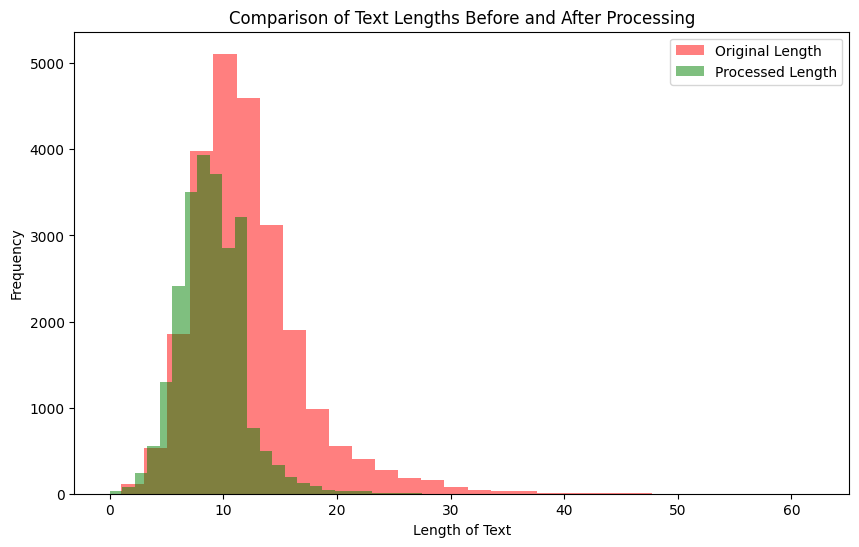

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(data['original_length'], bins=30, alpha=0.5, label='Original Length', color='red')
plt.hist(data['processed_text'].str.split().str.len(), bins=30, alpha=0.5, label='Processed Length', color='green')
plt.title('Comparison of Text Lengths Before and After Processing')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# EDA

Number of Entries, Non-Onion vs. Onion

In [ ]:
class_counts = data['label'].value_counts().rename(index={0: 'Non-Onion Headline', 1: 'Onion Headline'})
print(class_counts)

label
Non-Onion Headline    15000
Onion Headline         9000
Name: count, dtype: int64


**Examples of Onion and Non-Onion Headlines**

In [ ]:
print("5 Examples of Onion Headlines:")
print("-----------------------------------")
onion_examples = original_data[original_data['label'] == 1]['text'].sample(5).values
for example in onion_examples:
    print(example)

print("\n")

print("5 Examples of Non-Onion Headlines:")
print("-------------------------------------")
non_onion_examples = original_data[original_data['label'] == 0]['text'].sample(5).values
for example in non_onion_examples:
    print(example)

5 Examples of Onion Headlines:
-----------------------------------
Heavenly Sources Confirm Joe Jackson Already Screaming At Michael
John Bolton Warns War With North Korea Won’t Be Cakewalk Like Iraq
Poll: 89% Of Americans Believe Obama Has Failed To Bring America Closer To Celestial Utopia Of Endless Pleasure
Gynecologists Recommend Taking Time Off Between IUDs To Allow Body To Expel Backlogged Periods
Spanx Introduces New Line Of Smoke Bombs For Concealing Unwanted Bumps And Bulges


5 Examples of Non-Onion Headlines:
-------------------------------------
Woman Loses Hospice Care After Living Longer Than Expected
He let Jesus take the wheel, he told police. His truck flipped five times
Wisconsin Gun Club Seeks To Host Annual Gun Show At A Local Elementary School
Army can't track spending on $4.3b system to track spending, IG finds
Boyfriend jumps to his death after girlfriend insists they continue shopping


**Parents lose custody of child named 'Adolf Hitler' is an insane non-onion Headline**. Make sure to diplay this one...

**Text Analysis for "Onion" and "Not Onion" Headlines: Word Frequency, Text Length Distribution, and Class Distribution**

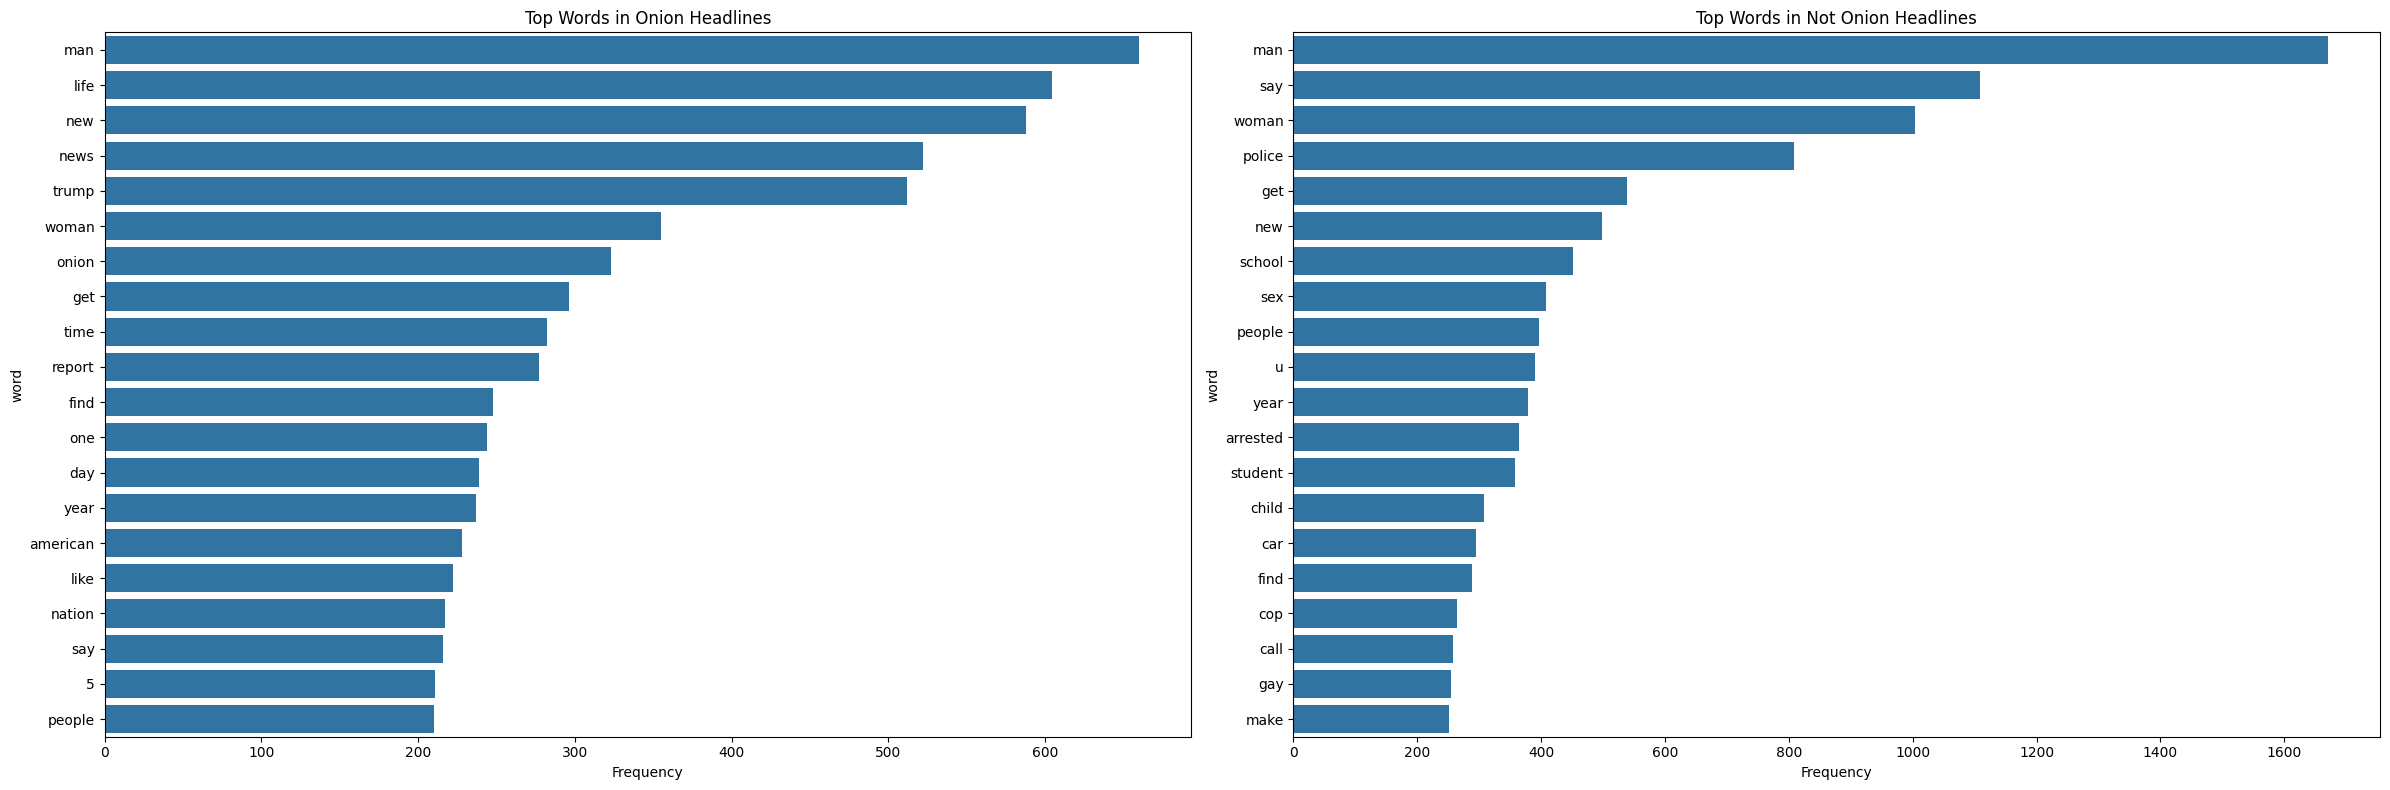

In [ ]:

def plot_word_frequency(texts1, texts2, title1, title2):
    words1 = ' '.join(texts1).split()
    word_freq1 = Counter(words1)
    freq_df1 = pd.DataFrame(word_freq1.items(), columns=['word', 'freq']).sort_values(by='freq', ascending=False).head(20)

    words2 = ' '.join(texts2).split()
    word_freq2 = Counter(words2)
    freq_df2 = pd.DataFrame(word_freq2.items(), columns=['word', 'freq']).sort_values(by='freq', ascending=False).head(20)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
    sns.barplot(x='freq', y='word', data=freq_df1, orient='h', ax=ax1)
    ax1.set_title(title1)
    ax1.set_xlabel('Frequency')
    sns.barplot(x='freq', y='word', data=freq_df2, orient='h', ax=ax2)
    ax2.set_title(title2)
    ax2.set_xlabel('Frequency')
    plt.tight_layout()
    plt.show()

not_onion_headlines = data[data['label'] == 0]['processed_text']
onion_headlines = data[data['label'] == 1]['processed_text']

plot_word_frequency(onion_headlines, not_onion_headlines, 'Top Words in Onion Headlines', 'Top Words in Not Onion Headlines')

**Word clouds for Onion and Non-Onionheadlines**

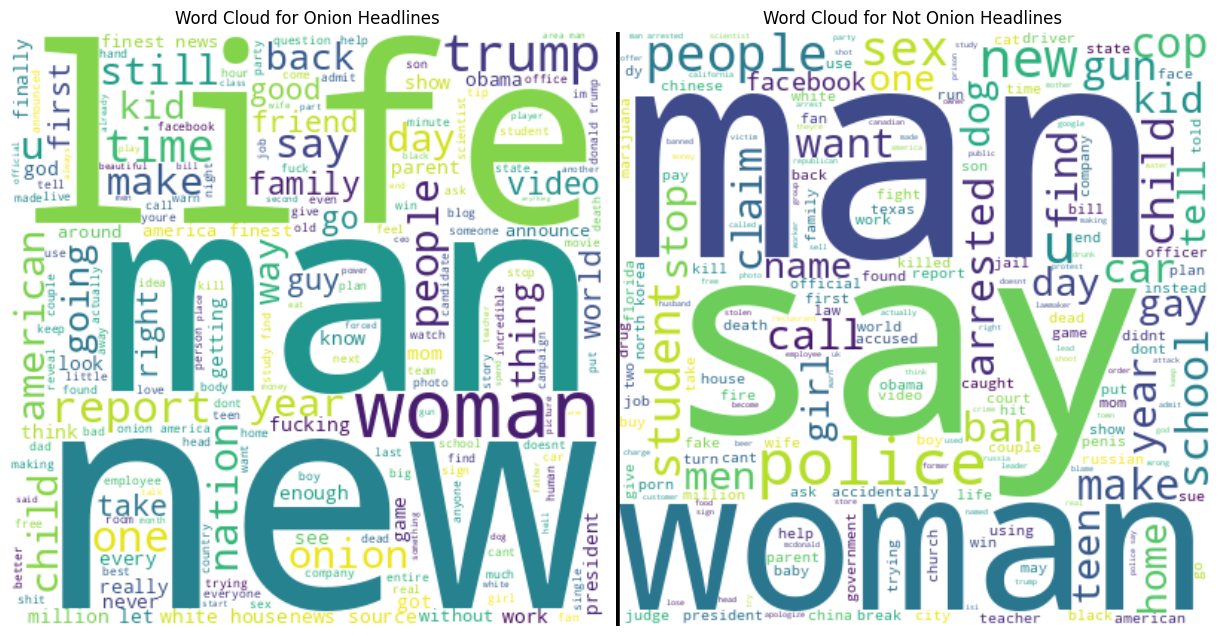

In [ ]:
onion_wordcloud = WordCloud(width=400, height=400, background_color='white').generate(' '.join(onion_headlines))
not_onion_wordcloud = WordCloud(width=400, height=400, background_color='white').generate(' '.join(not_onion_headlines))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))


ax1.imshow(onion_wordcloud, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Word Cloud for Onion Headlines')

ax2.imshow(not_onion_wordcloud, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Word Cloud for Not Onion Headlines')


plt.subplots_adjust(wspace=0.2)
fig.tight_layout()
fig.subplots_adjust(left=0.1, right=0.9)
fig.set_figwidth(15)

x = (fig.subplotpars.right + fig.subplotpars.left)/2
plt.axvline(x=x, color='black', linestyle='-', linewidth=4)

plt.show()

# Setup Bag of Words

In [ ]:
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(data['processed_text'])

X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42)

model = LogisticRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

score = accuracy_score(y_test,y_pred)
print("Model accuracy: ", score)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      3018
           1       0.80      0.74      0.77      1782

    accuracy                           0.83      4800
   macro avg       0.82      0.81      0.82      4800
weighted avg       0.83      0.83      0.83      4800

Model accuracy:  0.8329166666666666


**Confusion Matrix**

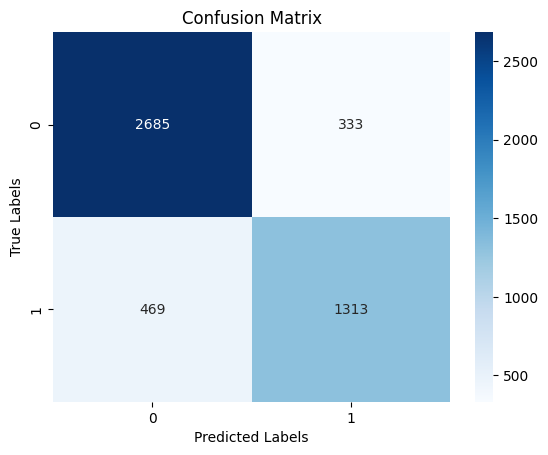

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Spacy

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

def preprocess_text_with_spacy(text):
    original_length = len(text.split())
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    doc = nlp(text)
    filtered_words = [token.lemma_ for token in doc if not token.is_stop]

    stop_words_count = original_length - len(filtered_words)

    return ' '.join(filtered_words), stop_words_count, original_length

data['processed_text_spacy'], data['stop_words_count_spacy'], data['original_length_spacy'] = zip(*data['text'].apply(preprocess_text_with_spacy))

In [ ]:
import random
indices = random.sample(range(len(data)), 1)

for idx in indices:
    print("Original Headline:")
    print(data['text'][idx], '\n')
    print("Headline After Preprocessing by removing stop words:")
    print(data['processed_text'][idx], '\n')
    print("Headline After Preprocessing with spaCy:")
    print(data['processed_text_spacy'][idx], '\n')
    print("\n---------------------------\n")


Original Headline:
Math, Science Popular Until Students Realize They’re Hard 

Headline After Preprocessing by removing stop words:
math science popular student realize theyre hard 

Headline After Preprocessing with spaCy:
math science popular student realize hard 


---------------------------



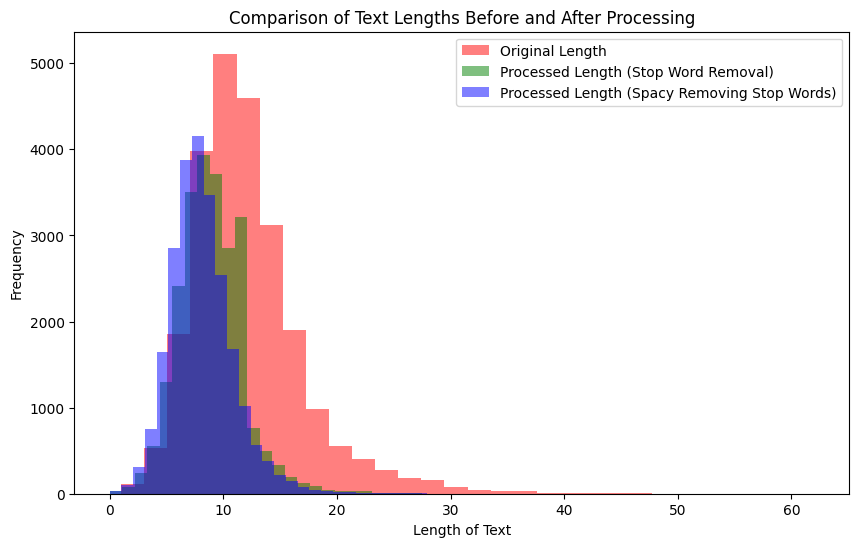

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(data['original_length'], bins=30, alpha=0.5, label='Original Length', color='red')
plt.hist(data['processed_text'].str.split().str.len(), bins=30, alpha=0.5, label='Processed Length (Stop Word Removal)', color='green')
plt.hist(data['processed_text_spacy'].str.split().str.len(), bins=30, alpha=0.5, label='Processed Length (Spacy Removing Stop Words)', color='blue')
plt.title('Comparison of Text Lengths Before and After Processing')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
X_spacy = vectorizer.fit_transform(data['processed_text_spacy'])
X_train_spacy, X_test_spacy, y_train_spacy, y_test_spacy = train_test_split(X_spacy, data['label'], test_size=0.2, random_state=42)

model_spacy = LogisticRegression()
model_spacy.fit(X_train_spacy, y_train_spacy)
y_pred_spacy = model_spacy.predict(X_test_spacy)

print("Performance with spaCy preprocessing:")
print(classification_report(y_test_spacy, y_pred_spacy))
score_spacy = accuracy_score(y_test_spacy, y_pred_spacy)
print("Model accuracy with spaCy preprocessing: ", score_spacy)


Performance with spaCy preprocessing:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      3018
           1       0.78      0.73      0.75      1782

    accuracy                           0.82      4800
   macro avg       0.81      0.80      0.81      4800
weighted avg       0.82      0.82      0.82      4800

Model accuracy with spaCy preprocessing:  0.8233333333333334


In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

def preprocess_text_with_spacy_with_stopwords(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    doc = nlp(text)
    filtered_words = [token.lemma_ for token in doc]
    return ' '.join(filtered_words)


data['processed_text_spacy_w_stopwords'] = data['text'].apply(preprocess_text_with_spacy_with_stopwords)

In [ ]:
import random
indices = random.sample(range(len(data)), 1)

for idx in indices:
    print("Original Headline:")
    print(data['text'][idx], '\n')
    print("Headline After Preprocessing by removing stop words:")
    print(data['processed_text'][idx], '\n')
    print("Headline After Preprocessing with spaCy removing stop words:")
    print(data['processed_text_spacy'][idx], '\n')
    print("Headline After Preprocessing with spaCy NOT removing stop words:")
    print(data['processed_text_spacy_w_stopwords'][idx], '\n')
    print("\n---------------------------\n")

Original Headline:
‘Blind’ Man Caught in Disability Fraud After Seen Driving a Speed Boat 

Headline After Preprocessing by removing stop words:
blind man caught disability fraud seen driving speed boat 

Headline After Preprocessing with spaCy removing stop words:
blind man catch disability fraud see drive speed boat 

Headline After Preprocessing with spaCy NOT removing stop words:
blind man catch in disability fraud after see drive a speed boat 


---------------------------



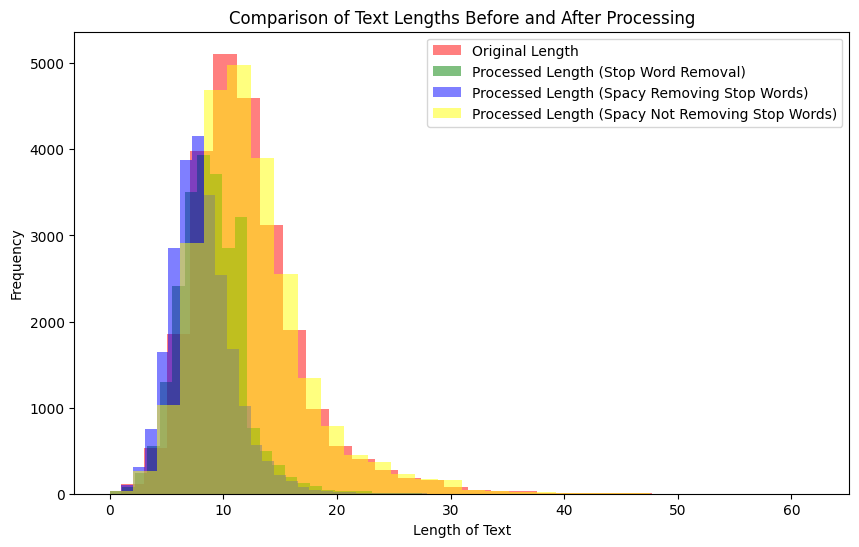

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(data['original_length'], bins=30, alpha=0.5, label='Original Length', color='red')
plt.hist(data['processed_text'].str.split().str.len(), bins=30, alpha=0.5, label='Processed Length (Stop Word Removal)', color='green')
plt.hist(data['processed_text_spacy'].str.split().str.len(), bins=30, alpha=0.5, label='Processed Length (Spacy Removing Stop Words)', color='blue')
plt.hist(data['processed_text_spacy_w_stopwords'].str.split().str.len(), bins=30, alpha=0.5, label='Processed Length (Spacy Not Removing Stop Words)', color='yellow')
plt.title('Comparison of Text Lengths Before and After Processing')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
X_spacy_with_stopwords = vectorizer.fit_transform(data['processed_text_spacy_w_stopwords'])
X_train_spacy_with_stopwords, X_test_spacy_with_stopwords, y_train_spacy_with_stopwords, y_test_spacy_with_stopwords = train_test_split(X_spacy_with_stopwords, data['label'], test_size=0.2, random_state=42)

model_spacy_with_stopwords = LogisticRegression(max_iter=1000)
model_spacy_with_stopwords.fit(X_train_spacy_with_stopwords, y_train_spacy_with_stopwords)
y_pred_spacy_with_stopwords = model_spacy_with_stopwords.predict(X_test_spacy_with_stopwords)

print("Performance with spaCy preprocessing including stop words:")
print(classification_report(y_test_spacy_with_stopwords, y_pred_spacy_with_stopwords))
score_spacy_with_stopwords = accuracy_score(y_test_spacy_with_stopwords, y_pred_spacy_with_stopwords)
print("Model accuracy with spaCy preprocessing including stop words: ", score_spacy_with_stopwords)


Performance with spaCy preprocessing including stop words:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      3018
           1       0.82      0.75      0.78      1782

    accuracy                           0.84      4800
   macro avg       0.84      0.83      0.83      4800
weighted avg       0.84      0.84      0.84      4800

Model accuracy with spaCy preprocessing including stop words:  0.8447916666666667


In [ ]:
def basic_pre(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

data['basic_pre_text'] = data['text'].apply(basic_pre)

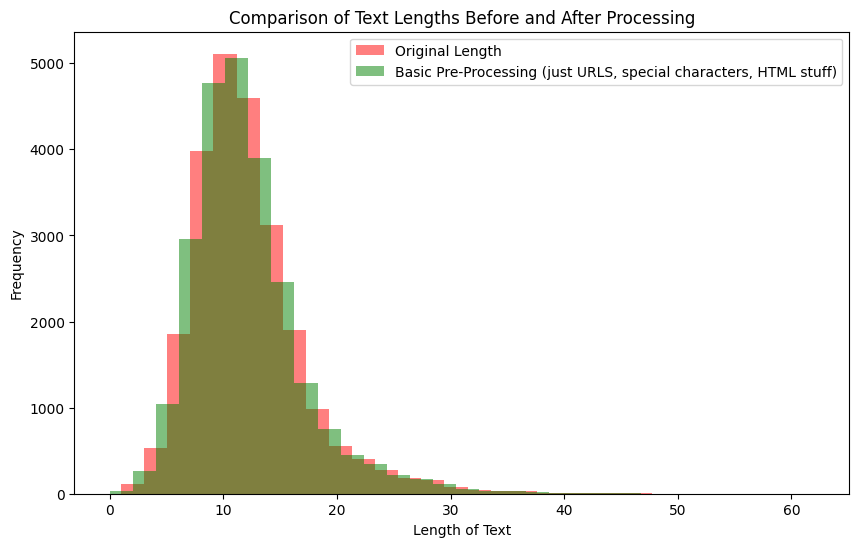

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(data['original_length'], bins=30, alpha=0.5, label='Original Length', color='red')
plt.hist(data['basic_pre_text'].str.split().str.len(), bins=30, alpha=0.5, label='Basic Pre-Processing (just URLS, special characters, HTML stuff)', color='green')
plt.title('Comparison of Text Lengths Before and After Processing')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
vectorizer = CountVectorizer()

X_original = vectorizer.fit_transform(data['basic_pre_text'])

X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_original, data['label'], test_size=0.2, random_state=42)

model_original = LogisticRegression(max_iter=1000)

model_original.fit(X_train_original, y_train_original)

y_pred_original = model_original.predict(X_test_original)

print("Performance on original text Basic Pre-Processing (just URLS, special characters, HTML stuff):")
print(classification_report(y_test_original, y_pred_original))
score_original = accuracy_score(y_test_original, y_pred_original)
print("Model accuracy on original Basic Pre-Processing (just URLS, special characters, HTML stuff): ", score_original)

Performance on original text Basic Pre-Processing (just URLS, special characters, HTML stuff):
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      3018
           1       0.82      0.76      0.79      1782

    accuracy                           0.85      4800
   macro avg       0.84      0.83      0.84      4800
weighted avg       0.85      0.85      0.85      4800

Model accuracy on original Basic Pre-Processing (just URLS, special characters, HTML stuff):  0.8497916666666666


In [ ]:
vectorizer = CountVectorizer()

X_original = vectorizer.fit_transform(data['text'])

X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_original, data['label'], test_size=0.2, random_state=42)

model_original = LogisticRegression(max_iter=1000)

model_original.fit(X_train_original, y_train_original)

y_pred_original = model_original.predict(X_test_original)

print("Performance on original text without spaCy and stop words removal:")
print(classification_report(y_test_original, y_pred_original))
score_original = accuracy_score(y_test_original, y_pred_original)
print("Model accuracy on original text without spaCy and stop words removal: ", score_original)

Performance on original text without spaCy and stop words removal:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89      3018
           1       0.83      0.76      0.79      1782

    accuracy                           0.85      4800
   macro avg       0.85      0.83      0.84      4800
weighted avg       0.85      0.85      0.85      4800

Model accuracy on original text without spaCy and stop words removal:  0.85375


# BytePair

In [ ]:
tokenizer = ByteLevelBPETokenizer()
texts = data['text'].tolist()
tokenizer.train_from_iterator(texts)

def tokenize_with_bpe(text):
    encoding = tokenizer.encode(text)
    return ' '.join(encoding.tokens)

vectorizer = CountVectorizer(tokenizer=tokenize_with_bpe)

X_bpe = vectorizer.fit_transform(data['text'])

X_train_bpe, X_test_bpe, y_train_bpe, y_test_bpe = train_test_split(X_bpe, data['label'], test_size=0.2, random_state=42)

model_bpe = LogisticRegression(max_iter=10000)

model_bpe.fit(X_train_bpe, y_train_bpe)

y_pred_bpe = model_bpe.predict(X_test_bpe)

print("Performance with Byte Pair Encoding and Logistic Regression:")
print(classification_report(y_test_bpe, y_pred_bpe))
score_bpe = accuracy_score(y_test_bpe, y_pred_bpe)
print("Model accuracy with Byte Pair Encoding and Logistic Regression: ", score_bpe)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Performance with Byte Pair Encoding and Logistic Regression:
              precision    recall  f1-score   support

           0       0.76      0.86      0.81      3018
           1       0.70      0.53      0.60      1782

    accuracy                           0.74      4800
   macro avg       0.73      0.70      0.71      4800
weighted avg       0.74      0.74      0.73      4800

Model accuracy with Byte Pair Encoding and Logistic Regression:  0.7414583333333333


In [ ]:
indices = random.sample(range(len(data)), 3)

for idx in indices:
    original_text = data['text'][idx]
    tokenized_text = tokenizer.encode(original_text).tokens
    print("Original Text:")
    print(original_text)
    print("Tokenized Text after BPE:")
    print(tokenized_text)
    print("\n---------------------------\n")

Original Text:
Logan Park ‘witches’ put hex on area to stop gentrification
Tokenized Text after BPE:
['Logan', 'ĠPark', 'ĠâĢĺ', 'w', 'itches', 'âĢĻ', 'Ġput', 'Ġhex', 'Ġon', 'Ġarea', 'Ġto', 'Ġstop', 'Ġgent', 'rification']

---------------------------

Original Text:
‘Now I Understand How Nazi Germany Happened,’ Says Astonished Man Finally Playing ‘Wolfenstein 3D’
Tokenized Text after BPE:
['âĢĺ', 'Now', 'ĠI', 'ĠUnderstand', 'ĠHow', 'ĠNazi', 'ĠGermany', 'ĠHappened', ',âĢĻ', 'ĠSays', 'ĠAston', 'ished', 'ĠMan', 'ĠFinally', 'ĠPlaying', 'ĠâĢĺ', 'Wolf', 'enstein', 'Ġ3', 'D', 'âĢĻ']

---------------------------

Original Text:
Tarantula Rushing To Shave Legs Before Meeting Up With Mate
Tokenized Text after BPE:
['T', 'arantula', 'ĠRushing', 'ĠTo', 'ĠShave', 'ĠLegs', 'ĠBefore', 'ĠMeeting', 'ĠUp', 'ĠWith', 'ĠMate']

---------------------------



# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(data['text'])

X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("Performance of Random Forest:")
print(classification_report(y_test, rf_preds))
score_rf = accuracy_score(y_test, rf_preds)
print("Model accuracy of Random Forest: ", score_rf)

Performance of Random Forest:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      3018
           1       0.82      0.62      0.71      1782

    accuracy                           0.81      4800
   macro avg       0.81      0.77      0.78      4800
weighted avg       0.81      0.81      0.80      4800

Model accuracy of Random Forest:  0.8095833333333333


In [ ]:
from sklearn.ensemble import RandomForestClassifier

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(data['processed_text'])

X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("Performance of Random Forest:")
print(classification_report(y_test, rf_preds))
score_rf = accuracy_score(y_test, rf_preds)
print("Model accuracy of Random Forest: ", score_rf)

Performance of Random Forest:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      3018
           1       0.76      0.70      0.73      1782

    accuracy                           0.81      4800
   macro avg       0.80      0.79      0.79      4800
weighted avg       0.81      0.81      0.81      4800

Model accuracy of Random Forest:  0.8083333333333333


In [ ]:
from sklearn.ensemble import RandomForestClassifier

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(data['processed_text_spacy'])

X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("Performance of Random Forest:")
print(classification_report(y_test, rf_preds))
score_rf = accuracy_score(y_test, rf_preds)
print("Model accuracy of Random Forest: ", score_rf)

Performance of Random Forest:
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      3018
           1       0.76      0.68      0.72      1782

    accuracy                           0.80      4800
   macro avg       0.79      0.78      0.78      4800
weighted avg       0.80      0.80      0.80      4800

Model accuracy of Random Forest:  0.8


In [ ]:
from sklearn.ensemble import RandomForestClassifier

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(data['processed_text_spacy_w_stopwords'])

X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("Performance of Random Forest:")
print(classification_report(y_test, rf_preds))
score_rf = accuracy_score(y_test, rf_preds)
print("Model accuracy of Random Forest: ", score_rf)

Performance of Random Forest:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      3018
           1       0.85      0.61      0.71      1782

    accuracy                           0.82      4800
   macro avg       0.82      0.77      0.79      4800
weighted avg       0.82      0.82      0.81      4800

Model accuracy of Random Forest:  0.8152083333333333


In [ ]:
from sklearn.ensemble import RandomForestClassifier

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(data['basic_pre_text'])

X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("Performance of Random Forest:")
print(classification_report(y_test, rf_preds))
score_rf = accuracy_score(y_test, rf_preds)
print("Model accuracy of Random Forest: ", score_rf)

Performance of Random Forest:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      3018
           1       0.82      0.62      0.71      1782

    accuracy                           0.81      4800
   macro avg       0.81      0.77      0.78      4800
weighted avg       0.81      0.81      0.80      4800

Model accuracy of Random Forest:  0.8108333333333333


In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_bpe, y_train_bpe)
rf_preds = rf.predict(X_test_bpe)

print("Performance of Random Forest:")
print(classification_report(y_test_bpe, rf_preds))
score_rf = accuracy_score(y_test_bpe, rf_preds)
print("Model accuracy of Random Forest: ", score_rf)

Performance of Random Forest:
              precision    recall  f1-score   support

           0       0.75      0.92      0.83      3018
           1       0.79      0.49      0.60      1782

    accuracy                           0.76      4800
   macro avg       0.77      0.71      0.72      4800
weighted avg       0.77      0.76      0.75      4800

Model accuracy of Random Forest:  0.7620833333333333


In [ ]:
from sklearn.model_selection import GridSearchCV

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(data['processed_text_spacy_w_stopwords'])

X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_

rf_preds = best_rf.predict(X_test)

print("Performance of Random Forest after hyperparameter tuning:")
print(classification_report(y_test, rf_preds))
score_rf = accuracy_score(y_test, rf_preds)
print("Model accuracy of Random Forest after hyperparameter tuning: ", score_rf)

Best hyperparameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Performance of Random Forest after hyperparameter tuning:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      3018
           1       0.90      0.59      0.71      1782

    accuracy                           0.82      4800
   macro avg       0.85      0.77      0.79      4800
weighted avg       0.84      0.82      0.81      4800

Model accuracy of Random Forest after hyperparameter tuning:  0.8222916666666666


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(data['processed_text_spacy_w_stopwords'])

X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42)

param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': [None] + list(randint(5, 50).rvs(10)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=3, scoring='accuracy', random_state=42)

random_search.fit(X_train, y_train)

print("Best hyperparameters:", random_search.best_params_)

best_rf = random_search.best_estimator_

rf_preds = best_rf.predict(X_test)

print("Performance of Random Forest after hyperparameter tuning with Randomized Search:")
print(classification_report(y_test, rf_preds))
score_rf = accuracy_score(y_test, rf_preds)
print("Model accuracy of Random Forest after hyperparameter tuning with Randomized Search: ", score_rf)


Best hyperparameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 17, 'n_estimators': 492}
Performance of Random Forest after hyperparameter tuning with Randomized Search:
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      3018
           1       0.92      0.58      0.71      1782

    accuracy                           0.82      4800
   macro avg       0.86      0.77      0.79      4800
weighted avg       0.84      0.82      0.81      4800

Model accuracy of Random Forest after hyperparameter tuning with Randomized Search:  0.8227083333333334


# Decision Tree

In [ ]:
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(data['text'])

X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42)

dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)

dt_preds = dt.predict(X_test)

print("Performance of Decision Tree:")
print(classification_report(y_test, dt_preds))
score_dt = accuracy_score(y_test, dt_preds)
print("Model accuracy of Decision Tree: ", score_dt)

Performance of Decision Tree:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      3018
           1       0.67      0.64      0.66      1782

    accuracy                           0.75      4800
   macro avg       0.73      0.73      0.73      4800
weighted avg       0.75      0.75      0.75      4800

Model accuracy of Decision Tree:  0.7510416666666667


In [ ]:
from sklearn.tree import DecisionTreeClassifier

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(data['processed_text'])

X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42)

dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)

dt_preds = dt.predict(X_test)

print("Performance of Decision Tree:")
print(classification_report(y_test, dt_preds))
score_dt = accuracy_score(y_test, dt_preds)
print("Model accuracy of Decision Tree: ", score_dt)


Performance of Decision Tree:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      3018
           1       0.64      0.68      0.66      1782

    accuracy                           0.74      4800
   macro avg       0.72      0.73      0.73      4800
weighted avg       0.74      0.74      0.74      4800

Model accuracy of Decision Tree:  0.7404166666666666


In [ ]:
from sklearn.tree import DecisionTreeClassifier

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(data['processed_text_spacy'])

X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42)

dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)

dt_preds = dt.predict(X_test)

print("Performance of Decision Tree:")
print(classification_report(y_test, dt_preds))
score_dt = accuracy_score(y_test, dt_preds)
print("Model accuracy of Decision Tree: ", score_dt)


Performance of Decision Tree:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      3018
           1       0.65      0.66      0.66      1782

    accuracy                           0.74      4800
   macro avg       0.72      0.73      0.73      4800
weighted avg       0.74      0.74      0.74      4800

Model accuracy of Decision Tree:  0.7422916666666667


In [ ]:
from sklearn.tree import DecisionTreeClassifier

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(data['basic_pre_text'])

X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42)

dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)

dt_preds = dt.predict(X_test)

print("Performance of Decision Tree:")
print(classification_report(y_test, dt_preds))
score_dt = accuracy_score(y_test, dt_preds)
print("Model accuracy of Decision Tree: ", score_dt)


Performance of Decision Tree:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      3018
           1       0.67      0.64      0.65      1782

    accuracy                           0.75      4800
   macro avg       0.73      0.73      0.73      4800
weighted avg       0.75      0.75      0.75      4800

Model accuracy of Decision Tree:  0.7472916666666667


In [ ]:
from sklearn.tree import DecisionTreeClassifier

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(data['processed_text_spacy_w_stopwords'])

X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42)

dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)

dt_preds = dt.predict(X_test)

print("Performance of Decision Tree:")
print(classification_report(y_test, dt_preds))
score_dt = accuracy_score(y_test, dt_preds)
print("Model accuracy of Decision Tree: ", score_dt)


Performance of Decision Tree:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      3018
           1       0.66      0.64      0.65      1782

    accuracy                           0.74      4800
   macro avg       0.72      0.72      0.72      4800
weighted avg       0.74      0.74      0.74      4800

Model accuracy of Decision Tree:  0.7433333333333333


In [ ]:
from sklearn.model_selection import GridSearchCV

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(data['text'])

X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42)

param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)

best_dt = grid_search.best_estimator_

dt_preds = best_dt.predict(X_test)

print("Performance of Decision Tree after hyperparameter tuning:")
print(classification_report(y_test, dt_preds))
score_dt = accuracy_score(y_test, dt_preds)
print("Model accuracy of Decision Tree after hyperparameter tuning: ", score_dt)

Best hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5}
Performance of Decision Tree after hyperparameter tuning:
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      3018
           1       0.64      0.61      0.63      1782

    accuracy                           0.73      4800
   macro avg       0.71      0.70      0.71      4800
weighted avg       0.73      0.73      0.73      4800

Model accuracy of Decision Tree after hyperparameter tuning:  0.7272916666666667


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(data['text'])

X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42)

param_dist = {
    'max_depth': [None] + list(randint(5, 50).rvs(10)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2']
}

dt = DecisionTreeClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=dt, param_distributions=param_dist, n_iter=1000, cv=5, scoring='accuracy', random_state=42)

random_search.fit(X_train, y_train)

print("Best hyperparameters:", random_search.best_params_)

best_dt = random_search.best_estimator_

dt_preds = best_dt.predict(X_test)

print("Performance of Decision Tree after hyperparameter tuning with Randomized Search:")
print(classification_report(y_test, dt_preds))
score_dt = accuracy_score(y_test, dt_preds)
print("Model accuracy of Decision Tree after hyperparameter tuning with Randomized Search: ", score_dt)


Best hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 9}
Performance of Decision Tree after hyperparameter tuning with Randomized Search:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      3018
           1       0.65      0.56      0.60      1782

    accuracy                           0.73      4800
   macro avg       0.71      0.69      0.70      4800
weighted avg       0.72      0.73      0.72      4800

Model accuracy of Decision Tree after hyperparameter tuning with Randomized Search:  0.7254166666666667


# Building and Training the CNN Model



In [ ]:
X_cnn = data['text']
Y_cnn = data['label']

X_train_plus_val, X_test, y_train_plus_val, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_plus_val, y_train_plus_val, test_size=0.25, random_state=42)

max_words = 10000
max_len = 300
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len)
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_len)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len)

In [ ]:
embedding_dim = 300
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_val_padded, y_val), callbacks=[early_stopping])

y_pred_prob = model.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Epoch 1/10
450/450 [==============================] - 161s 354ms/step - loss: 0.4486 - accuracy: 0.7872 - val_loss: 0.3455 - val_accuracy: 0.8500
Epoch 2/10
450/450 [==============================] - 151s 334ms/step - loss: 0.1795 - accuracy: 0.9362 - val_loss: 0.3775 - val_accuracy: 0.8498
Epoch 3/10
450/450 [==============================] - 157s 349ms/step - loss: 0.0486 - accuracy: 0.9842 - val_loss: 0.5527 - val_accuracy: 0.8383
Epoch 4/10
150/150 [==============================] - 13s 85ms/step
Accuracy: 0.8685416666666667
Precision: 0.8391278727165586
Recall: 0.7991021324354658
F1-score: 0.8186260419660822


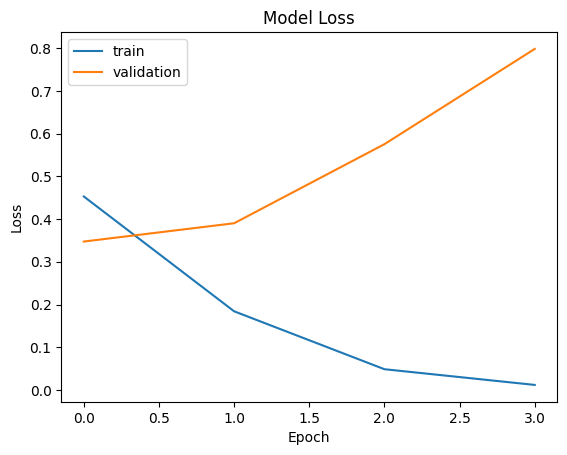

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

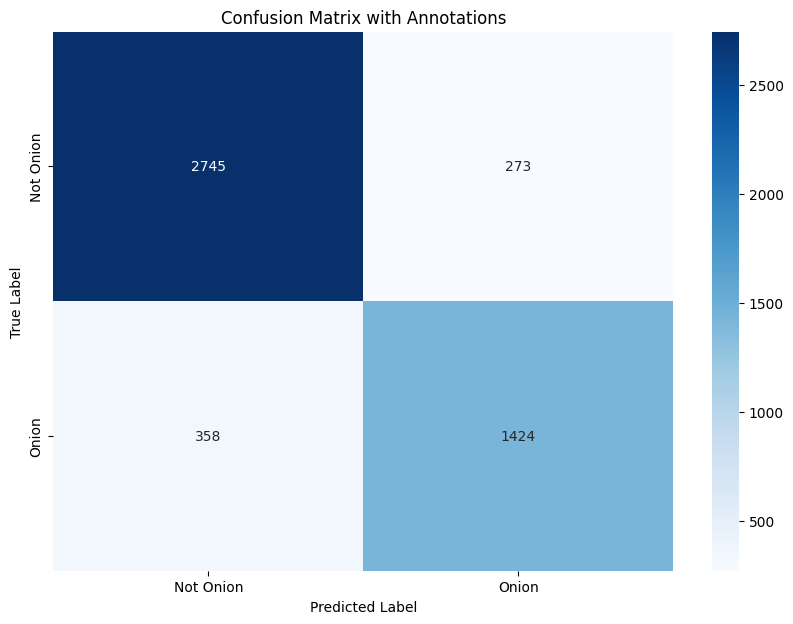

In [ ]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Onion', 'Onion'], yticklabels=['Not Onion', 'Onion'])
plt.title('Confusion Matrix with Annotations')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

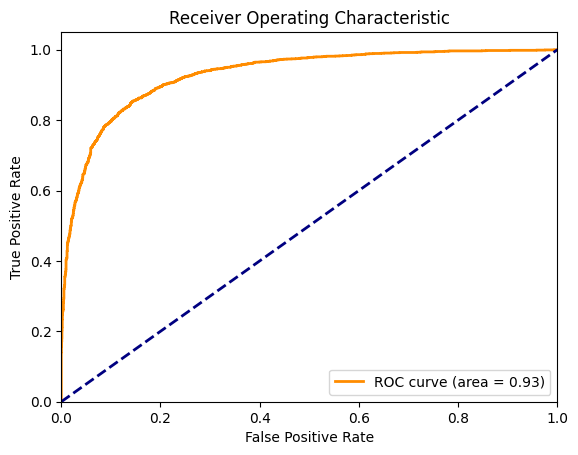

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Building and Training the LSTM Model

In [ ]:
X_train_plus_val, X_test, y_train_plus_val, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_plus_val, y_train_plus_val, test_size=0.25, random_state=42)

max_words = 10000
max_len = 300
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len)
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_len)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len)

In [ ]:
X_train_sequences[1]

[759, 2369, 6356, 1479, 1480, 2, 1145, 1, 2172, 2173, 8, 1048, 4430]

In [ ]:
max(len(seq) for seq in X_train_sequences)

60

In [ ]:
X_train_padded[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [ ]:
X_train[1]

'Muslim Woman Denied Soda Can for Fear She Could Use It as a Weapon'

## LSTM with High Dropout

In [ ]:
embedding_dim = 128

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(LSTM(embedding_dim, recurrent_dropout = 0.8))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_data=(X_val_padded, y_val), callbacks=[early_stopping])

y_pred_prob = model.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Epoch 1/5
450/450 [==============================] - 379s 829ms/step - loss: 0.4493 - accuracy: 0.7845 - val_loss: 0.3430 - val_accuracy: 0.8523
Epoch 2/5
450/450 [==============================] - 372s 826ms/step - loss: 0.2187 - accuracy: 0.9142 - val_loss: 0.3801 - val_accuracy: 0.8477
Epoch 3/5
450/450 [==============================] - 420s 935ms/step - loss: 0.1238 - accuracy: 0.9567 - val_loss: 0.4460 - val_accuracy: 0.8417
Epoch 4/5
150/150 [==============================] - 20s 135ms/step
Accuracy: 0.8625
Precision: 0.8183881952326901
Recall: 0.8092031425364759
F1-score: 0.8137697516930023


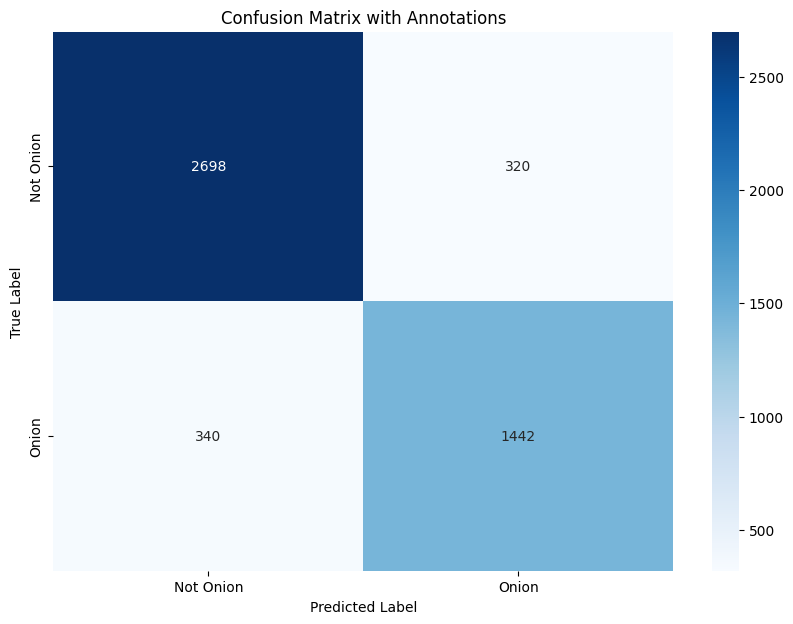

In [ ]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Onion', 'Onion'], yticklabels=['Not Onion', 'Onion'])
plt.title('Confusion Matrix with Annotations')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

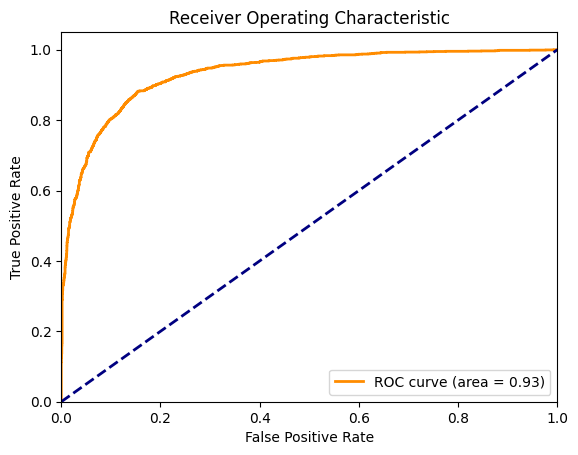

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## LSTM 0.3 dropout

In [ ]:
embedding_dim = 128

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(LSTM(embedding_dim, recurrent_dropout = 0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_data=(X_val_padded, y_val), callbacks=[early_stopping])

y_pred_prob = model.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Epoch 1/5
450/450 [==============================] - 381s 829ms/step - loss: 0.4272 - accuracy: 0.7983 - val_loss: 0.3411 - val_accuracy: 0.8527
Epoch 2/5
450/450 [==============================] - 395s 878ms/step - loss: 0.2041 - accuracy: 0.9212 - val_loss: 0.3986 - val_accuracy: 0.8500
Epoch 3/5
450/450 [==============================] - 390s 866ms/step - loss: 0.1140 - accuracy: 0.9598 - val_loss: 0.4510 - val_accuracy: 0.8396
Epoch 4/5
150/150 [==============================] - 21s 139ms/step
Accuracy: 0.8652083333333334
Precision: 0.8062601187263896
Recall: 0.8383838383838383
F1-score: 0.8220082530949105


# AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = data[['processed_text', 'stop_words_count', 'original_length']]
y = data['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()

X_train_processed_text = vectorizer.fit_transform(X_train['processed_text'])

X_test_processed_text = vectorizer.transform(X_test['processed_text'])

X_train_features = np.hstack((X_train_processed_text.toarray(), X_train[['stop_words_count', 'original_length']].values))

X_test_features = np.hstack((X_test_processed_text.toarray(), X_test[['stop_words_count', 'original_length']].values))

adaboost = AdaBoostClassifier(n_estimators=50, random_state=42)

adaboost.fit(X_train_features, y_train)

adaboost_predictions = adaboost.predict(X_test_features)

adaboost_accuracy = accuracy_score(y_test, adaboost_predictions)


In [ ]:
print(f"AdaBoost Accuracy: {adaboost_accuracy:.4f}")

adaboost_report = classification_report(y_test, adaboost_predictions)
print("AdaBoost Classification Report:")
print(adaboost_report)

adaboost_cm = confusion_matrix(y_test, adaboost_predictions)
print("AdaBoost Confusion Matrix:")
print(adaboost_cm)


AdaBoost Accuracy: 0.7467
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.89      0.82      3018
           1       0.73      0.50      0.60      1782

    accuracy                           0.75      4800
   macro avg       0.74      0.70      0.71      4800
weighted avg       0.74      0.75      0.73      4800

AdaBoost Confusion Matrix:
[[2690  328]
 [ 888  894]]


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(chi2, k=100)
X_train_selected = selector.fit_transform(X_train_features, y_train)
X_test_selected = selector.transform(X_test_features)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0]
}

adaboost = AdaBoostClassifier(random_state=42)

grid_search = GridSearchCV(estimator=adaboost, param_grid=param_grid, cv=5)
grid_search.fit(X_train_selected, y_train)

best_adaboost = grid_search.best_estimator_
adaboost_predictions = best_adaboost.predict(X_test_selected)

adaboost_accuracy = accuracy_score(y_test, adaboost_predictions)
print(f"AdaBoost Accuracy: {adaboost_accuracy:.4f}")

adaboost_report = classification_report(y_test, adaboost_predictions)
print("AdaBoost Classification Report:")
print(adaboost_report)

adaboost_cm = confusion_matrix(y_test, adaboost_predictions)
print("AdaBoost Confusion Matrix:")
print(adaboost_cm)


AdaBoost Accuracy: 0.7656
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.83      3018
           1       0.74      0.57      0.64      1782

    accuracy                           0.77      4800
   macro avg       0.76      0.72      0.73      4800
weighted avg       0.76      0.77      0.76      4800

AdaBoost Confusion Matrix:
[[2668  350]
 [ 775 1007]]


# Open AI GPT Baseline Model Classifcation

In [ ]:
!pip install openai scikit-learn pandas matplotlib seaborn wordcloud plotly

In [ ]:
import os
from openai import OpenAI

client = OpenAI(
    api_key="api-key"
)


In [ ]:
def classify_with_openai(headline, model):
   response = client.chat.completions.create(
       model=model,
       messages=[
           {"role": "system", "content": "You are a classifier."},
           {"role": "user", "content": f"Classify the following headline as 'Onion' or 'Not Onion': {headline}"}
       ]
   )
   result = response.choices[0].message.content.strip()
   return result

def classify_with_openai40(headline):
   return classify_with_openai(headline, "gpt-4o")

def classify_with_openai4(headline):
   return classify_with_openai(headline, "gpt-4")

def classify_with_openai35(headline):
   return classify_with_openai(headline, "gpt-3.5-turbo")

def classify_with_openai_finetune(headline):
   return classify_with_openai(headline, "ft:gpt-3.5-turbo-1106:valiant-solutions:onion:9OxBpVB4")

In [ ]:
import time
true_labels = data['label'].tolist()
def get_predictions(classify_func, time_limit):
   start_time = time.time()
   openai_predictions = []
   total_headlines = len(data['processed_text'])
   for i, headline in enumerate(data['processed_text']):
       if time.time() - start_time > time_limit:
           print("Time limit reached, stopping execution.")
           break
       prediction = classify_func(headline)
       openai_predictions.append(prediction)
       print(f"{i + 1}/{total_headlines}")
   return openai_predictions

time_limit = 300

predictions_40 = get_predictions(classify_with_openai40, time_limit)
predictions_4 = get_predictions(classify_with_openai4, time_limit)
predictions_35 = get_predictions(classify_with_openai35, time_limit)
predictions_finetune = get_predictions(classify_with_openai_finetune, time_limit)

def evaluate_model(predictions, true_labels):
   predictions_binary = [1 if pred.lower() == 'onion' else 0 for pred in predictions]
   true_labels_binary = [1 if label == 1 else 0 for label in true_labels[:len(predictions)]]

   accuracy = accuracy_score(true_labels_binary, predictions_binary)
   report = classification_report(true_labels_binary, predictions_binary, output_dict=True)
   cm = confusion_matrix(true_labels_binary, predictions_binary)

   return accuracy, report, cm, true_labels_binary, predictions_binary

accuracy_40, report_40, cm_40, true_labels_binary_40, predictions_binary_40 = evaluate_model(predictions_40, true_labels)
accuracy_4, report_4, cm_4, true_labels_binary_4, predictions_binary_4 = evaluate_model(predictions_4, true_labels)
accuracy_35, report_35, cm_35, true_labels_binary_35, predictions_binary_35 = evaluate_model(predictions_35, true_labels)
accuracy_finetune, report_finetune, cm_finetune, true_labels_binary_finetune, predictions_binary_finetune = evaluate_model(predictions_finetune, true_labels)


1/24000
2/24000
3/24000
4/24000
5/24000
6/24000
7/24000
8/24000
9/24000
10/24000
11/24000
12/24000
13/24000
14/24000
15/24000
16/24000
17/24000
18/24000
19/24000
20/24000
21/24000
22/24000
23/24000
24/24000
25/24000
26/24000
27/24000
28/24000
29/24000
30/24000
31/24000
32/24000
33/24000
34/24000
35/24000
36/24000
37/24000
38/24000
39/24000
40/24000
41/24000
42/24000
43/24000
44/24000
45/24000
46/24000
47/24000
48/24000
49/24000
50/24000
51/24000
52/24000
53/24000
54/24000
55/24000
56/24000
57/24000
58/24000
59/24000
60/24000
61/24000
62/24000
63/24000
64/24000
65/24000
66/24000
67/24000
68/24000
69/24000
70/24000
71/24000
72/24000
73/24000
74/24000
75/24000
76/24000
77/24000
78/24000
79/24000
80/24000
81/24000
82/24000
83/24000
84/24000
85/24000
86/24000
87/24000
88/24000
89/24000
90/24000
91/24000
92/24000
93/24000
94/24000
95/24000
96/24000
97/24000
98/24000
99/24000
100/24000
101/24000
102/24000
103/24000
104/24000
105/24000
106/24000
107/24000
108/24000
109/24000
110/24000
111/2400

In [ ]:
print(f"GPT-4o Model Accuracy: {accuracy_40}")
print(f"GPT-4 Model Accuracy: {accuracy_4}")
print(f"GPT-3.5 Model Accuracy: {accuracy_35}")
print(f"Finetuned GPT-3.5 Model Accuracy: {accuracy_finetune}")

Finetuned GPT-3.5 Model Accuracy: 0.6476997578692494


In [ ]:
def display_evaluation_data(report, accuracy, model_name):
    print(f"\nPerformance with {model_name} Classification:")
    report_df = pd.DataFrame(report).transpose()
    print(report_df)
    print(f"\nModel accuracy with {model_name} classification: {accuracy}")

In [ ]:
display_evaluation_data(report_40, accuracy_40, "GPT-4o")



Performance with GPT-4o Classification:
              precision    recall  f1-score     support
0              0.742222  0.554817  0.634981  301.000000
1              0.486590  0.686486  0.569507  185.000000
accuracy       0.604938  0.604938  0.604938    0.604938
macro avg      0.614406  0.620652  0.602244  486.000000
weighted avg   0.644914  0.604938  0.610058  486.000000

Model accuracy with GPT-4o classification: 0.6049382716049383


In [ ]:
display_evaluation_data(report_4, accuracy_4, "GPT-4")


Performance with GPT-4 Classification:
              precision    recall  f1-score     support
0              0.719101  0.810127  0.761905  237.000000
1              0.601770  0.475524  0.531250  143.000000
accuracy       0.684211  0.684211  0.684211    0.684211
macro avg      0.660436  0.642826  0.646577  380.000000
weighted avg   0.674948  0.684211  0.675106  380.000000

Model accuracy with GPT-4 classification: 0.6842105263157895


In [ ]:
display_evaluation_data(report_35, accuracy_35, "GPT-3.5-turbo")


Performance with GPT-3.5-turbo Classification:
              precision    recall  f1-score    support
0              0.631188  0.958647  0.761194  266.00000
1              0.592593  0.096970  0.166667  165.00000
accuracy       0.628770  0.628770  0.628770    0.62877
macro avg      0.611890  0.527808  0.463930  431.00000
weighted avg   0.616413  0.628770  0.533591  431.00000

Model accuracy with GPT-3.5-turbo classification: 0.62877030162413


In [ ]:
display_evaluation_data(report_finetune, accuracy_finetune, "Finetuned GPT-3.5-turbo")


Performance with Finetuned GPT-3.5-turbo Classification:
              precision    recall  f1-score   support
0              0.657609  0.925430  0.768864  523.0000
1              0.566667  0.168317  0.259542  303.0000
accuracy       0.647700  0.647700  0.647700    0.6477
macro avg      0.612138  0.546874  0.514203  826.0000
weighted avg   0.624249  0.647700  0.582030  826.0000

Model accuracy with Finetuned GPT-3.5-turbo classification: 0.6476997578692494


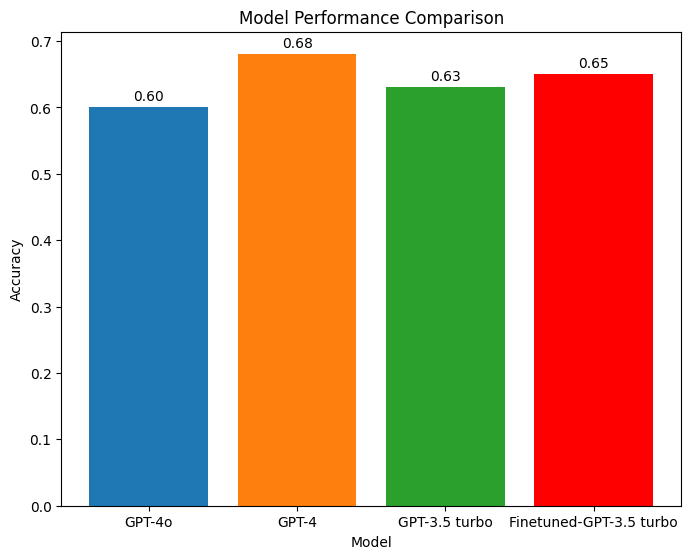

In [ ]:
import matplotlib.pyplot as plt

accuracies = [.60, .68, .63, .65]
model_names = ['GPT-4o', 'GPT-4', 'GPT-3.5 turbo', 'Finetuned-GPT-3.5 turbo']

fig, ax = plt.subplots(figsize=(8, 6))
bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c','red']
bar_positions = range(len(accuracies))
ax.bar(bar_positions, accuracies, color=bar_colors)

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance Comparison')
ax.set_xticks(bar_positions)
ax.set_xticklabels(model_names)

for i, accuracy in enumerate(accuracies):
    ax.text(i, accuracy + 0.01, f'{accuracy:.2f}', ha='center')

plt.subplots_adjust(top=0.9)

plt.show()

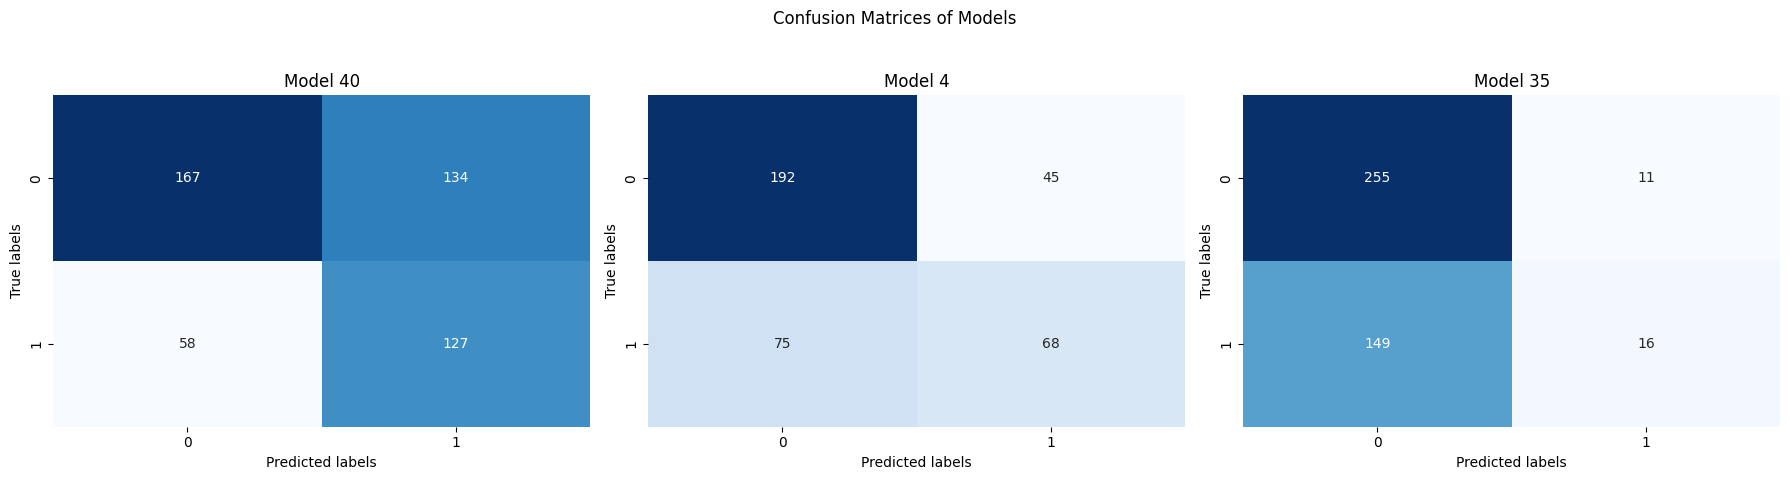

In [ ]:
accuracies = [accuracy_40, accuracy_4, accuracy_35]
confusion_matrices = [cm_40, cm_4, cm_35]
models = ['Model 40', 'Model 4', 'Model 35']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices of Models')

for i, (cm, model) in enumerate(zip(confusion_matrices, models)):
    sns.heatmap(cm, annot=True, fmt="d", ax=axes[i], cmap='Blues', cbar=False)
    axes[i].set_title(f'{model}')
    axes[i].set_xlabel('Predicted labels')
    axes[i].set_ylabel('True labels')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
